In [ ]:
!pip install -r ./requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 2.6 MB/s eta 0:00:00 MB/s eta 0:00:01
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 10.5 MB/s eta 0:00:00
  Using cached certifi-2024.8.30-py3-none-any.whl (167 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 1.7 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 1.8 MB/s eta 0:00:001.7 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 6.3 MB/s eta 0:00:006.3 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 9.2 MB/s eta 0:00:00m eta 0:00:010:00:01m
  Using cached executing-2.1.0-py2.py3-none-any.whl (25 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 9.5 MB/s eta 0:00:00m eta

In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from statsforecast import StatsForecast
from statsforecast.models import HistoricAverage, Naive, RandomWalkWithDrift, SeasonalNaive, WindowAverage, SeasonalWindowAverage, AutoARIMA
import statsmodels.api as sm
np.float_ = np.float64
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics


In [21]:
def timeseries_metrics(y_true, y_pred) -> dict:
    """
    Calcula indicadores de validação para um modelo de séries temporais.
    
    Parâmetros:
    y_true (array-like): Valores reais da série temporal.
    y_pred (array-like): Valores previstos pelo modelo.

    Retorna:
    dict: Dicionário com os indicadores de validação.
    """

    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)


    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
    }

# Captura dos dados

Os dados do Ibovespa foram capturados a partir de 1995 através de um web scraping do site [investing.com](https://br.investing.com/indices/bovespa-historical-data) (código presente no arquivo extract.py)

# Leitura dos dados
Para a análise só serão nessárias as colunas rowDate (data) e last_close (variável que será feita a previsão)

In [8]:
df_petroleo = pd.read_excel("./data/raw/rbrted.xls", sheet_name="Data 1", skiprows=2)
df_petroleo = df_petroleo.rename(columns={"Date": "ds", "Europe Brent Spot Price FOB (Dollars per Barrel)": "y"})
df_petroleo.sort_values("ds", inplace=True)
df_petroleo.tail()

,ds,y
9559,2025-01-21,80.57
9560,2025-01-22,80.00
9561,2025-01-23,78.62
9562,2025-01-24,78.71
9563,2025-01-27,77.30


# Análise inicial dos dados

## Completude dos dados

Primeiramente realizamos uma checagem de completude dos dados. Conforme visto abaixo, não existem dados nulos e existem dados apenas para dias úteis.

In [9]:
df_petroleo.isnull().sum()

ds    0
y     0
dtype: int64

In [13]:
weekdays = df_petroleo["ds"].dt.weekday.unique()
weekdays.sort()
weekdays

array([0, 1, 2, 3, 4], dtype=int32)

## Visualização inicial dos dados

* Visualmente é possível notar que a série tem uma tendência de crescimento.
* Vales no gráfico:
  * pouco depois de 2008 por conta da crise
  * em 2016 por conta do impeachment
  * em 2020 por conta da pandemia.

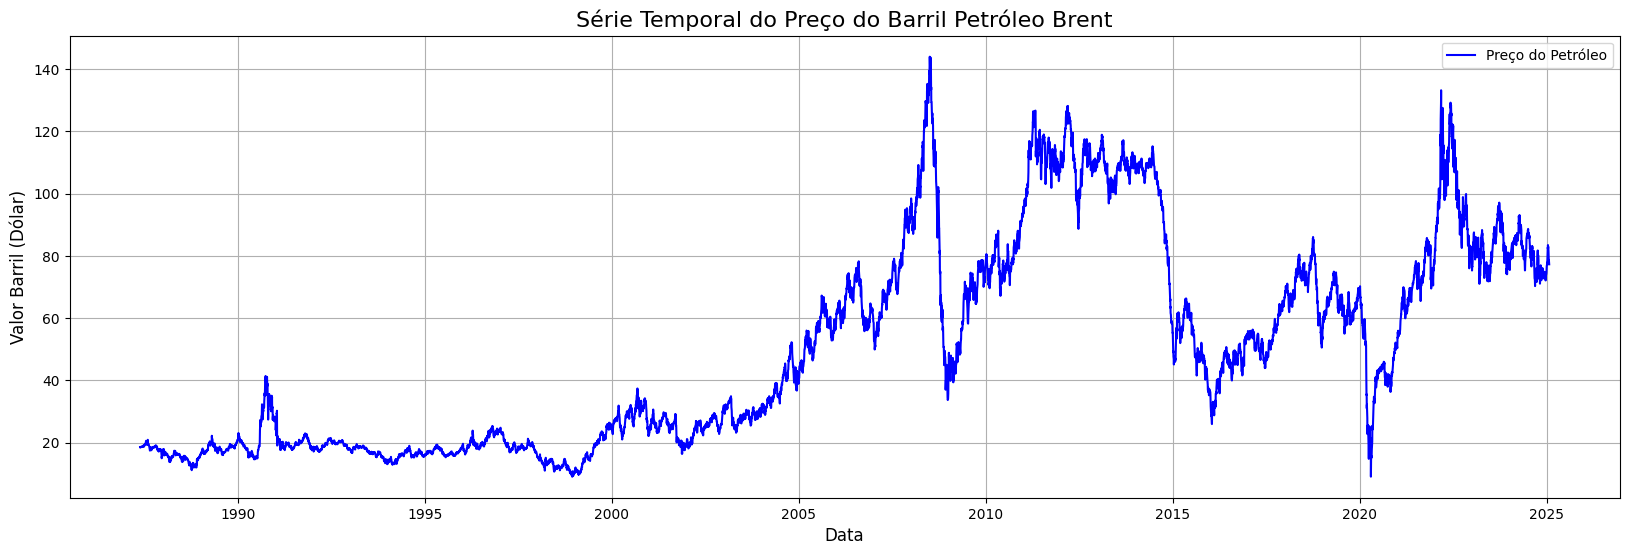

In [14]:
plt.figure(figsize=(20, 6))
plt.plot(df_petroleo['ds'], df_petroleo['y'], label="Preço do Petróleo", color='blue')
plt.title('Série Temporal do Preço do Barril Petróleo Brent', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Valor Barril (Dólar)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## Decomposição da Série Temporal

### Pré-tratamento
Para fazer a decomposição, é necessário ter a data como índice do DataFrame e para adicionar a frequência neste índice foi preciso adicionar as datas faltantes (feriados)

### Modelos de decomposição

* **Modelo Aditivo**: é adequado quando a amplitude da sazonalidade é constante ao longo do tempo. Ou seja, a variação sazonal não aumenta nem diminui à medida que o nível da série muda. Por exemplo, em dados de vendas onde o aumento das vendas ao longo do tempo não altera a variação sazonal, o modelo aditivo seria apropriado. Exemplo: Vendas de produtos que têm variações sazonais fixas, como aumentos em dezembro por causa do Natal, mas as variações sazonais não aumentam proporcionalmente com o volume de vendas ao longo dos anos.<br><br>
* **Modelo Multiplicativo** é adequado quando a amplitude da variação sazonal aumenta ou diminui com o nível da série temporal. Em outras palavras, quanto maior o valor da série, maior a variação sazonal. Exemplo: Índices financeiros, como mencionado anteriormente. Quando os níveis da série (valores do índice) aumentam, a variação sazonal também cresce proporcionalmente.

### Resultados
Há a confirmação da tendência crescente e é possível ver uma sazonalidade de aproximadamente 1 ano.



In [15]:
df_date_index = df_petroleo[["ds", "y"]].copy()
df_date_index.index = df_date_index["ds"]
df_date_index.drop("ds", inplace=True, axis=1)
df_date_index = df_date_index.asfreq('B').ffill()

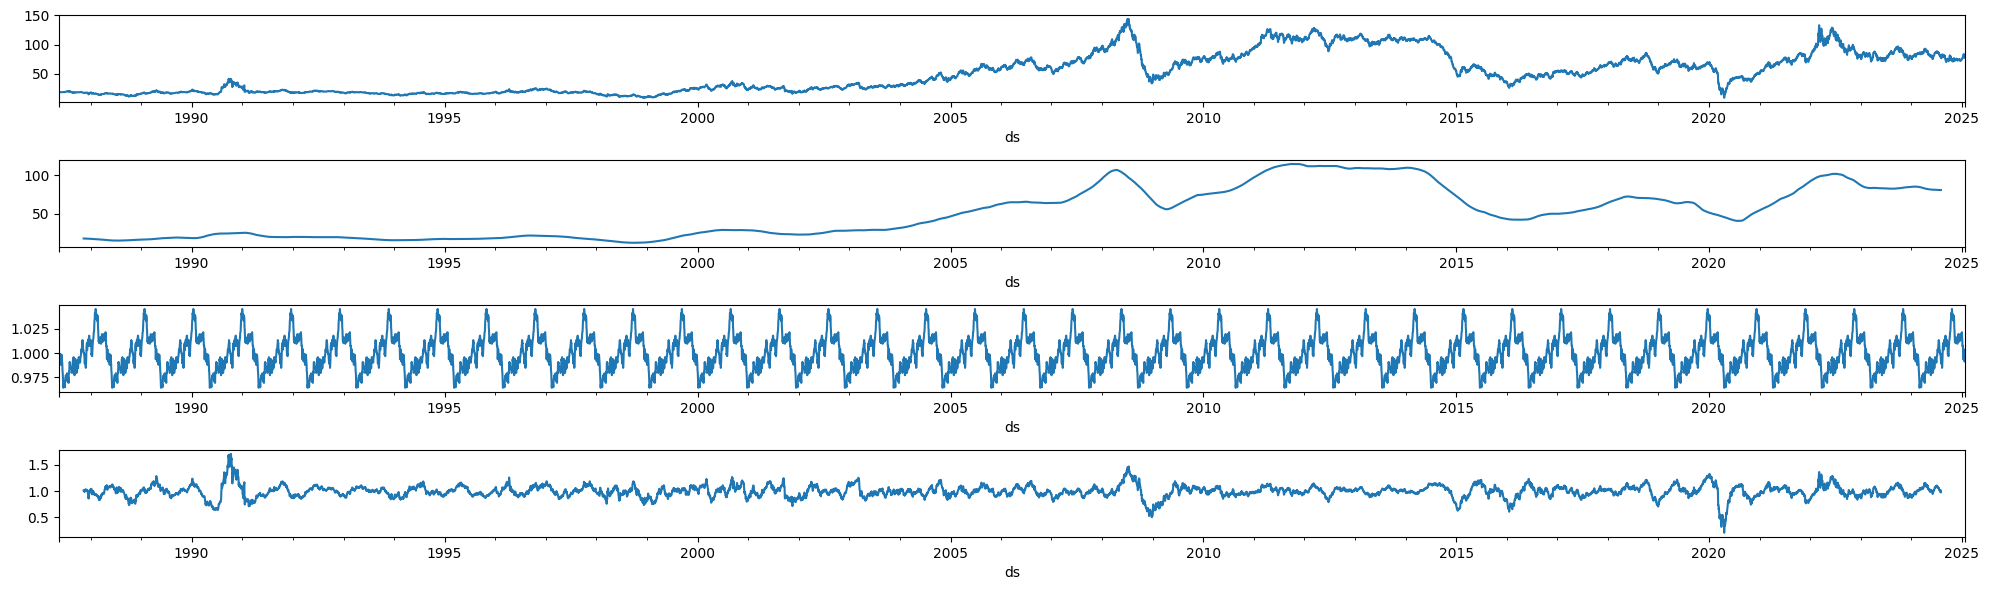

In [16]:
resultados = seasonal_decompose(df_date_index, period=252, model="multiplicative")
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (20,6))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

## Criação dos Modelos

### Definições
- **Janela de previsão:** Para criação dos modelos, escolhemos trabalhar com uma predição curta de 5 dias. O mercado é extremamente dinâmico, e os preços são influenciados por uma série de fatores que mudam rapidamente, como notícias econômicas, decisões políticas e até eventos globais inesperados. Ao prever apenas cinco dias à frente, conseguimos capturar essas mudanças mais imediatas sem deixar que o modelo seja afetado com incertezas que aumentam em horizontes mais longos. Portanto, a escolha da janela de 5 dias é uma forma de focar em previsões mais acionáveis e ajustadas à realidade do mercado, sem tentar adivinhar o futuro distante com pouca precisão.<br><br>
- **Método de teste:** Ao escolher utilizar uma janela de tempo curta, não faz sentido testar os modelos utilizando o método tradicional de separar os dados em treino e teste. Ao invés disso, iremos testar com base no método cross-validation, que percorre a série temporal fazendo previsões em vários pontos, dando um resultado mais confiável e evitando o overfit.

### Modelos de Baseline

Modelos baseline são modelos simples usados como ponto de referência para avaliar o desempenho de modelos mais complexos em tarefas de aprendizado de máquina. Eles fornecem uma linha de base para comparar os resultados e entender a complexidade do problema, fornecendo uma referência para determinar se o uso de técnicas mais avançadas é justificável.
<br><br>A seguir estão os testes usando os modelos:
1. HistoricAverage
2. Naive
3. RandomWalkWithDrift
4. SeasonalNaive
5. WindowAverage
6. SeasonalWindowAverage



In [33]:
def show_sf_results(df):
    models = [c for c in df.columns if c not in ['ds', 'y', "cutoff"]]
    for col in models:
        print(col)
        metrics = timeseries_metrics(df['y'].values, df[col].values)
        print("\n".join([f"{k}: {v}" if k != "MAPE" else f"{k}: {v:.2%}" for k, v in metrics.items()]))
        print("#"*10+"\n")

    _, axs = plt.subplots(len(models), 1, figsize=(10, 4*len(models)))
    axs = axs if len(models) > 1 else [axs]
    for i, ax in enumerate(axs):
        ax.plot(df['ds'][-15:], df[models[i]][-15:], label='Previsão', color='#1f3979')
        ax.plot(df['ds'][-15:], df['y'][-15:], label='Real', color='#e34592')
        ax.set_title(models[i], fontsize=20)
        ax.set_xlabel('Ano')
        ax.set_ylabel('Fechamento (Pontos)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend()
    plt.tight_layout()

In [62]:
df_stats_forecast = df_petroleo.copy()
df_stats_forecast["unique_id"] = 1

In [52]:
model = StatsForecast(models=[HistoricAverage(), Naive(), RandomWalkWithDrift(), SeasonalNaive(season_length=5), WindowAverage(window_size=15), SeasonalWindowAverage(season_length=5, window_size=15)], freq="B", n_jobs=-1)
df_cross = model.cross_validation(df=df_stats_forecast, h=15, step_size=60, n_windows=114
)
df_cross = df_cross.dropna()

/home/rafael-pinheiro/.pyenv/versions/3.10.13/envs/venv-pos/lib/python3.10/site-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


HistoricAverage
MAE: 30.447324301885104
RMSE: 39.266875802429674
MAPE: 42.80%
##########

Naive
MAE: 2.722029239766082
RMSE: 4.123612770460116
MAPE: 4.85%
##########

RWD
MAE: 2.7193817613753746
RMSE: 4.123038040005096
MAPE: 4.86%
##########

SeasonalNaive
MAE: 3.094830409356725
RMSE: 4.441745968812488
MAPE: 5.59%
##########

WindowAverage
MAE: 3.7142042884990256
RMSE: 5.1473613407191285
MAPE: 6.57%
##########

SeasWA
MAE: 6.343512280701755
RMSE: 9.462112377314892
MAPE: 12.09%
##########



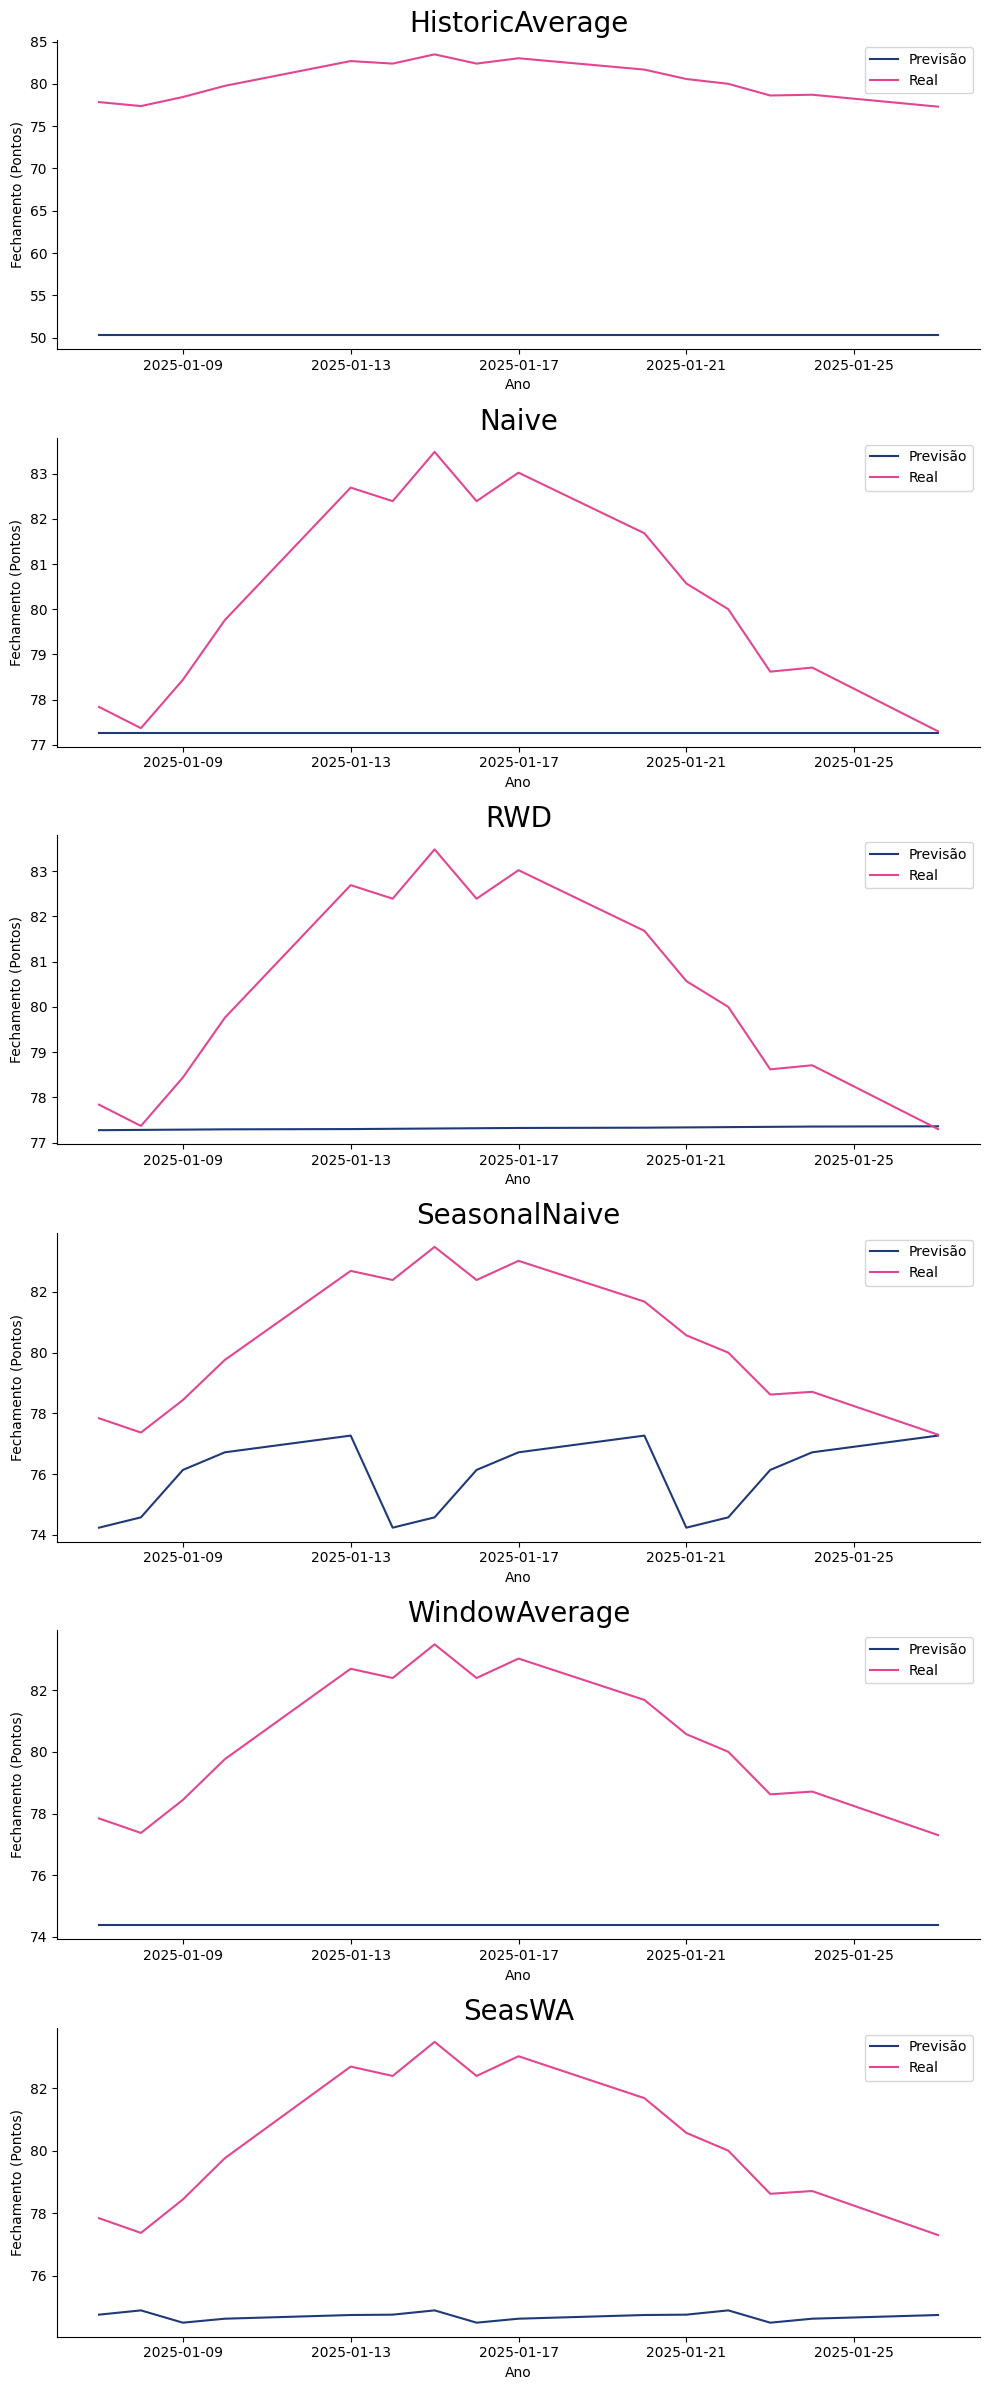

In [53]:
show_sf_results(df_cross)

### Modelos avançados

#### ARIMA

##### Estacionariedade dos dados

Foi necessária 1 diferenciação para tornar os dados estacionários

In [23]:
df_arima = df_petroleo.loc[df_petroleo["ds"] >= "2010-01-01"]

Diferenciação 1 - ADF Statistic: -26.707858732977986, p-value: 0.0, Critical Values: {'1%': -3.4320693157877544, '5%': -2.8622996992165364, '10%': -2.5671743978048323}
Série estacionária após 1 diferenciações.


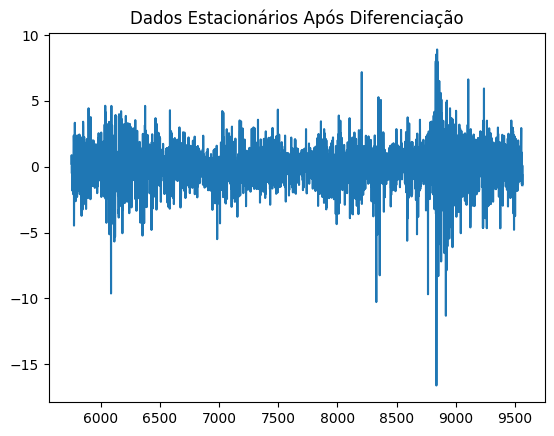

In [24]:
def check_stationarity(data, max_diff=5):
    diff_count = 0
    adf_result = sm.tsa.adfuller(data)

    while adf_result[1] >= 0.05 and diff_count < max_diff:
        diff_count += 1
        data = data.diff().dropna()  # Diferenciar a série
        adf_result = sm.tsa.adfuller(data)
        print(f"Diferenciação {diff_count} - ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}, Critical Values: {adf_result[4]}")

    if adf_result[1] < 0.05:
        print(f"Série estacionária após {diff_count} diferenciações.")
        ax = data.plot()
        ax.set_title("Dados Estacionários Após Diferenciação")
    else:
        print(f"Série não estacionária após {max_diff} diferenciações.")

# Chamada da função
check_stationarity(df_arima["y"])

In [40]:
model = StatsForecast(models=[AutoARIMA(d=1)], freq="B", n_jobs=-1)
df_cross_arima = model.cross_validation(df=df_status_forecast, h=15, step_size=60, n_windows=114
)
df_cross_arima = df_cross_arima.dropna()

/home/rafael-pinheiro/.pyenv/versions/3.10.13/envs/venv-pos/lib/python3.10/site-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


AutoARIMA
MAE: 2.7320538802443894
RMSE: 4.1289901433451135
MAPE: 4.87%
##########



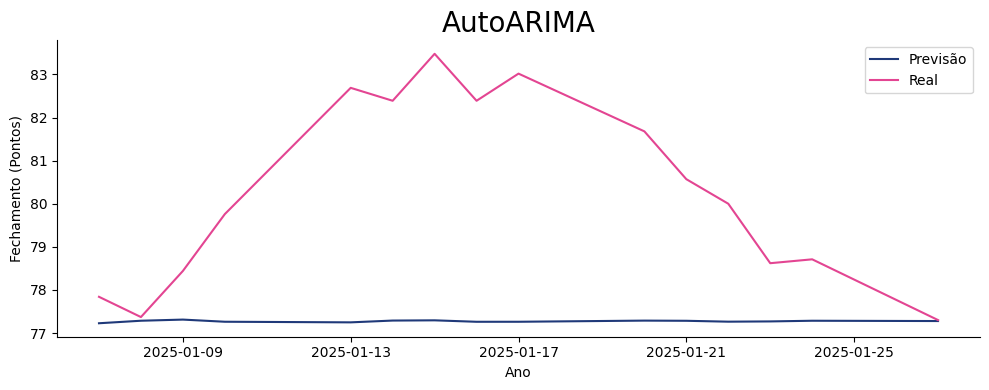

In [41]:
show_sf_results(df_cross_arima)

#### Prophet

In [ ]:
years = df_petroleo.ds.dt.year.unique()

In [46]:
m = Prophet()
m.fit(df_petroleo[:-15])

16:55:36 - cmdstanpy - INFO - Chain [1] start processing
16:55:38 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
future = m.make_future_dataframe(periods=15, freq="B")
forecast = m.predict(future)

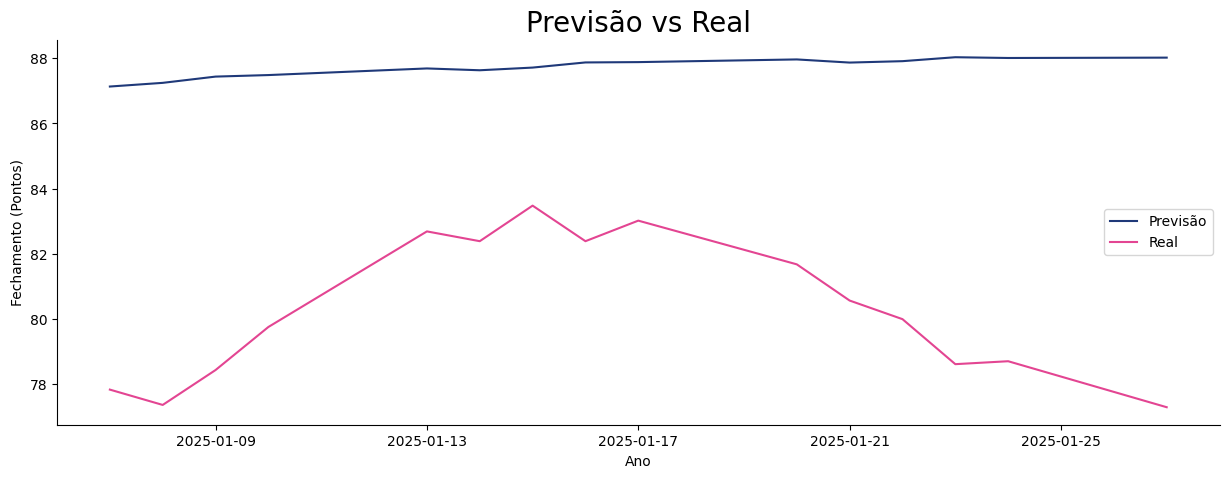

In [48]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(forecast['ds'][-15:], forecast['yhat'][-15:], label='Previsão', color='#1f3979')
ax.plot(df_petroleo['ds'][-15:], df_petroleo['y'][-15:], label='Real', color='#e34592')
ax.set_title('Previsão vs Real', fontsize=20)
ax.set_xlabel('Ano')
ax.set_ylabel('Fechamento (Pontos)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

In [54]:
df_cv = cross_validation(
    m,
    initial='366 days',
    period='60 days',
    horizon='15 days'
)
df_pm = performance_metrics(df_cv)

  0%|          | 0/223 [00:00<?, ?it/s]16:57:59 - cmdstanpy - INFO - Chain [1] start processing
16:57:59 - cmdstanpy - INFO - Chain [1] done processing
16:57:59 - cmdstanpy - INFO - Chain [1] start processing
16:57:59 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/223 [00:00<00:11, 19.61it/s]16:57:59 - cmdstanpy - INFO - Chain [1] start processing
16:57:59 - cmdstanpy - INFO - Chain [1] done processing
16:57:59 - cmdstanpy - INFO - Chain [1] start processing
16:57:59 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 4/223 [00:00<00:12, 16.85it/s]16:57:59 - cmdstanpy - INFO - Chain [1] start processing
16:57:59 - cmdstanpy - INFO - Chain [1] done processing
16:57:59 - cmdstanpy - INFO - Chain [1] start processing
16:57:59 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 6/223 [00:00<00:14, 14.67it/s]16:57:59 - cmdstanpy - INFO - Chain [1] start processing
16:57:59 - cmdstanpy - INFO - Chain [1] done processing
16:57:59 - cmdstanpy - INFO -

In [55]:
df_pm

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,294.413174,17.158472,11.200027,0.219894,0.143969,0.209317,0.441083
1,3 days,289.677818,17.019924,10.914928,0.211634,0.152961,0.202683,0.438710
2,4 days,275.672781,16.603397,10.639446,0.207696,0.138945,0.197548,0.450584
3,5 days,270.475672,16.446145,10.832516,0.214260,0.129946,0.204675,0.434546
4,6 days,268.536030,16.387069,10.825454,0.215071,0.129637,0.206824,0.429534
5,7 days,278.424833,16.686067,10.824494,0.213015,0.141880,0.204375,0.458120
6,8 days,301.482462,17.363250,11.313993,0.225930,0.143451,0.214216,0.447136
7,9 days,298.712503,17.283301,11.310649,0.223469,0.152962,0.213687,0.444805
8,10 days,273.079809,16.525127,10.831601,0.211413,0.141959,0.206185,0.429316
9,11 days,267.564261,16.357392,10.785838,0.212195,0.146163,0.205703,0.438404


In [63]:
model = StatsForecast(models=[SeasonalNaive(season_length=5)], freq="B", n_jobs=-1)
model = model.fit(df_stats_forecast)
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

/home/rafael-pinheiro/.pyenv/versions/3.10.13/envs/venv-pos/lib/python3.10/site-packages/statsforecast/core.py:476: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/home/rafael-pinheiro/.pyenv/versions/3.10.13/envs/venv-pos/lib/python3.10/site-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,SeasonalNaive
0,2025-01-28,80.57
1,2025-01-29,80.00
2,2025-01-30,78.62
3,2025-01-31,78.71
4,2025-02-03,77.30
5,2025-02-04,80.57
6,2025-02-05,80.00
7,2025-02-06,78.62
8,2025-02-07,78.71
9,2025-02-10,77.30
